In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q originals_03.zip -d /content/data

In [ ]:
!unzip -q predict_02.zip -d /content/data

In [ ]:
!unzip -q masks_03.zip -d /content/data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [ ]:
from tensorflow.keras.models import load_model

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + epsilon) / (denominator + epsilon)

final_model = load_model('/content/drive/MyDrive/models/final_tuned_model_4_layers.keras', custom_objects={'dice_loss': dice_loss})

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 395ms/step - accuracy: 0.9806 - loss: 0.0727 - val_accuracy: 0.9804 - val_loss: 0.0998
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9820 - loss: 0.0675 - val_accuracy: 0.9799 - val_loss: 0.1015
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9820 - loss: 0.0668 - val_accuracy: 0.9799 - val_loss: 0.1003
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9823 - loss: 0.0661 - val_accuracy: 0.9799 - val_loss: 0.1006
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9821 - loss: 0.0666 - val_accuracy: 0.9804 - val_loss: 0.0985
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9825 - loss: 0.0647 - val_accuracy: 0.9807 - val_loss: 0.0965
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9825 - loss: 0.0648 - val_accuracy: 0.9811 - val_loss: 0.0948
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9827 - loss: 0.0636 - val_accuracy: 

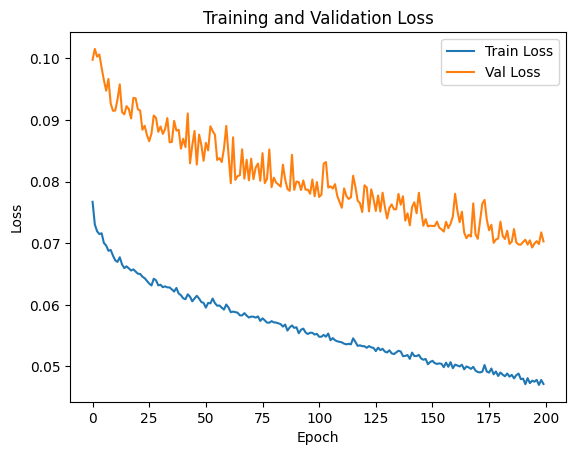

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_image_pair(original_path, mask_path):
    """
    Loads and preprocesses a pair of images (original and mask) from the given file paths.
    Returns two tensors of shape (IMG_HEIGHT, IMG_WIDTH, 1) normalized to [0, 1].
    """
    original_image = tf.io.read_file(original_path)
    original_image = tf.image.decode_png(original_image, channels=1)
    original_image = tf.image.resize(original_image, [IMG_HEIGHT, IMG_WIDTH])
    original_image = tf.cast(original_image, tf.float32) / 255.0

    mask_image = tf.io.read_file(mask_path)
    mask_image = tf.image.decode_png(mask_image, channels=1)
    mask_image = tf.image.resize(mask_image, [IMG_HEIGHT, IMG_WIDTH])
    mask_image = tf.cast(mask_image, tf.float32) / 255.0

    return original_image, mask_image

def augment(original_image, mask_image):
    """
    Randomly flips the images horizontally and/or vertically.
    """
    if tf.random.uniform(()) > 0.5:
        original_image = tf.image.flip_left_right(original_image)
        mask_image = tf.image.flip_left_right(mask_image)
    if tf.random.uniform(()) > 0.5:
        original_image = tf.image.flip_up_down(original_image)
        mask_image = tf.image.flip_up_down(mask_image)
    return original_image, mask_image

def get_matched_file_pairs(originals_dir, masks_dir):
    """
    Returns matched pairs of (original, mask) image file paths by filename.
    """
    orig_files = {os.path.basename(f): os.path.join(originals_dir, f) for f in os.listdir(originals_dir) if f.endswith('.png')}
    mask_files = {os.path.basename(f): os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')}
    matched = sorted(set(orig_files.keys()) & set(mask_files.keys()))
    orig_paths = [orig_files[f] for f in matched]
    mask_paths = [mask_files[f] for f in matched]
    return orig_paths, mask_paths

def get_dataset_from_lists(orig_list, mask_list, batch_size=8, augment_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((orig_list, mask_list))
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_tiny_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)
    return models.Model(inputs=[inputs], outputs=[outputs])

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + epsilon) / (denominator + epsilon)

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + epsilon) / (denominator + epsilon)

def evaluate_dice_on_dataset(model, dataset, dice_fn, threshold=0.5):
    dices = []
    for batch in dataset:
        x, y_true = batch
        y_pred = model.predict(x)
        y_pred_bin = (y_pred > threshold).astype(np.float32)
        y_true_bin = (y_true.numpy() > threshold).astype(np.float32)
        for i in range(y_true.shape[0]):
            dice = dice_fn(tf.convert_to_tensor(y_true_bin[i]), tf.convert_to_tensor(y_pred_bin[i])).numpy()
            dices.append(dice)
    mean_dice = np.mean(dices)
    print(f"Mean Dice coefficient: {mean_dice:.4f}")
    return mean_dice

if __name__ == "__main__":
    originals_dir = '/content/data/originals_03'
    masks_dir = '/content/data/masks_03'
    batch_size = 8
    # 1. Get matched file pairs
    orig_paths, mask_paths = get_matched_file_pairs(originals_dir, masks_dir)
    # 2. Split into train/val/test (70/15/15)
    train_orig, temp_orig, train_mask, temp_mask = train_test_split(orig_paths, mask_paths, test_size=0.3, random_state=42)
    val_orig, test_orig, val_mask, test_mask = train_test_split(temp_orig, temp_mask, test_size=0.5, random_state=42)
    # 3. Build datasets
    train_dataset = get_dataset_from_lists(train_orig, train_mask, batch_size=batch_size, augment_data=True)
    val_dataset = get_dataset_from_lists(val_orig, val_mask, batch_size=batch_size, augment_data=False)
    test_dataset = get_dataset_from_lists(test_orig, test_mask, batch_size=batch_size, augment_data=False)
    # 4. Build and train model
    model = final_model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=dice_loss, metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200)
    # 5. Evaluate on validation and test set
    print("Validation set:")
    evaluate_dice_on_dataset(model, val_dataset, dice_coefficient)
    print("Test set:")
    evaluate_dice_on_dataset(model, test_dataset, dice_coefficient)
    # Optional: plot training curves
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
import os

save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)  # Creates the folder if it doesn't exist

model.save(os.path.join(save_dir, 'final_tuned_model_4_layers.keras'))

In [ ]:
import os
IMG_HEIGHT = 256
IMG_WIDTH = 256
def preprocess_single_image(image_path):
    """
    Loads and preprocesses a single image for prediction.
    Args:
        image_path (str): File path to the image.
    Returns:
        tf.Tensor: Preprocessed image tensor of shape (IMG_HEIGHT, IMG_WIDTH, 1).
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_images_for_prediction(directory):
    """
    Loads and preprocesses all PNG images from a directory for prediction.
    Args:
        directory (str): Path to the directory containing images.
    Returns:
        np.ndarray: Array of preprocessed images of shape (N, IMG_HEIGHT, IMG_WIDTH, 1).
        list: List of image file names.
    """
    image_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')])
    images = [preprocess_single_image(f) for f in image_files]
    images = tf.stack(images)
    return images.numpy(), image_files

# Example usage for prediction:
predict_dir = '/content/data/predict_02'
new_images, image_paths = load_images_for_prediction(predict_dir)
predicted_edges = final_model.predict(new_images)
# dice_scores = dice_coefficient(tf.convert_to_tensor(masks_04), tf.convert_to_tensor(predicted_edges))

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step


In [ ]:
import numpy as np

# Check if the predictions exist
if 'predicted_edges' in locals():
    # 1. Binarize the output: thresholding probabilities to 0 or 1
    # Values above the threshold become 1, others become 0
    threshold = 0.5
    export_volume = (predicted_edges > threshold).astype(np.uint8)

    # 2. Save as Raw Binary (.bin)
    file_name = "02_skull_mask_binary.bin"
    export_volume.tofile(file_name)

    print(f"✅ Binary mask (0 and 1) saved: {file_name}")
    print(f"--- Metadata ---")
    print(f"Threshold applied: {threshold}")
    print(f"Unique values in file: {np.unique(export_volume)}")
    print(f"Dimensions (Depth, Height, Width, Channels): {export_volume.shape}")

    print("\n💡 WebGPU Tip: If using 'r8unorm' textures, the value 1 maps to 1/255 intensity.")
    print("To get full intensity (1.0), you would need to multiply by 255 before saving.")
else:
    print("❌ Error: 'predicted_edges' not found. Please run the prediction cell first.")

✅ Binary mask (0 and 1) saved: 02_skull_mask_binary.bin
--- Metadata ---
Threshold applied: 0.5
Unique values in file: [0 1]
Dimensions (Depth, Height, Width, Channels): (192, 256, 256, 1)

💡 WebGPU Tip: If using 'r8unorm' textures, the value 1 maps to 1/255 intensity.
To get full intensity (1.0), you would need to multiply by 255 before saving.


### Detailed Visualization of Predictions with Dice Coefficients

This section provides a visual comparison of original images, the model's predictions, and the corresponding ground truth masks, along with the calculated Dice coefficient for a few selected slices from the prediction dataset. This helps in understanding the model's performance at an individual image level.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Ensure dice_coefficient function is available (from previous cells)
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + epsilon) / (denominator + epsilon)

# Ensure `new_images`, `predicted_edges`, `ground_truth_masks`, and `dice_scores`
# are available from previous cells (e.g., cell '0f8c913c').
# If not, please run those cells first.

if 'new_images' not in locals() or \
   'predicted_edges' not in locals() or \
   'ground_truth_masks' not in locals() or \
   'dice_scores' not in locals():
    print("Error: Required variables for visualization are not found.")
    print("Please ensure cells calculating predictions and dice scores have been run.")
else:
    # Select a few slice indices for detailed visualization
    # You can adjust these indices to focus on specific examples
    visualization_indices = [100, 340, 330, 300]

    print("Visualizing selected prediction slices with Dice Coefficients...")
    for i, slice_idx in enumerate(visualization_indices):
        if slice_idx < len(new_images):
            current_dice_score = dice_scores[slice_idx]

            plt.figure(figsize=(15, 5))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(new_images[slice_idx, ..., 0], cmap='gray')
            plt.title(f'Original (Slice {slice_idx})')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 2)
            plt.imshow(predicted_edges[slice_idx, ..., 0], cmap='Reds')
            plt.title(f'Predicted Mask')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 3)
            plt.imshow(ground_truth_masks[slice_idx, ..., 0], cmap='Blues')
            plt.title(f'Ground Truth (Dice: {current_dice_score:.4f})')
            plt.axis('off')

            plt.suptitle(f'Slice {slice_idx} - Dice Coefficient: {current_dice_score:.4f}', fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
            plt.show()
        else:
            print(f"Warning: Slice index {slice_idx} is out of bounds for the prediction dataset.")


Error: Required variables for visualization are not found.
Please ensure cells calculating predictions and dice scores have been run.


Saving original vs predicted plots to: /content/processed_images
Visualizing selected prediction slices with Dice Coefficients...


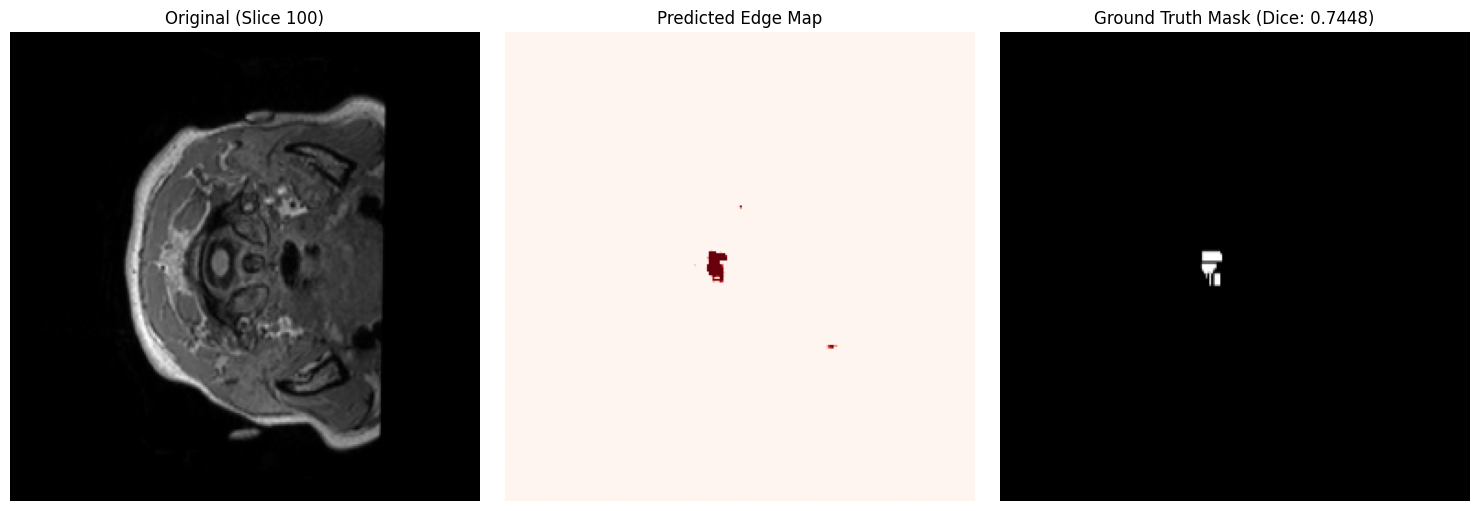

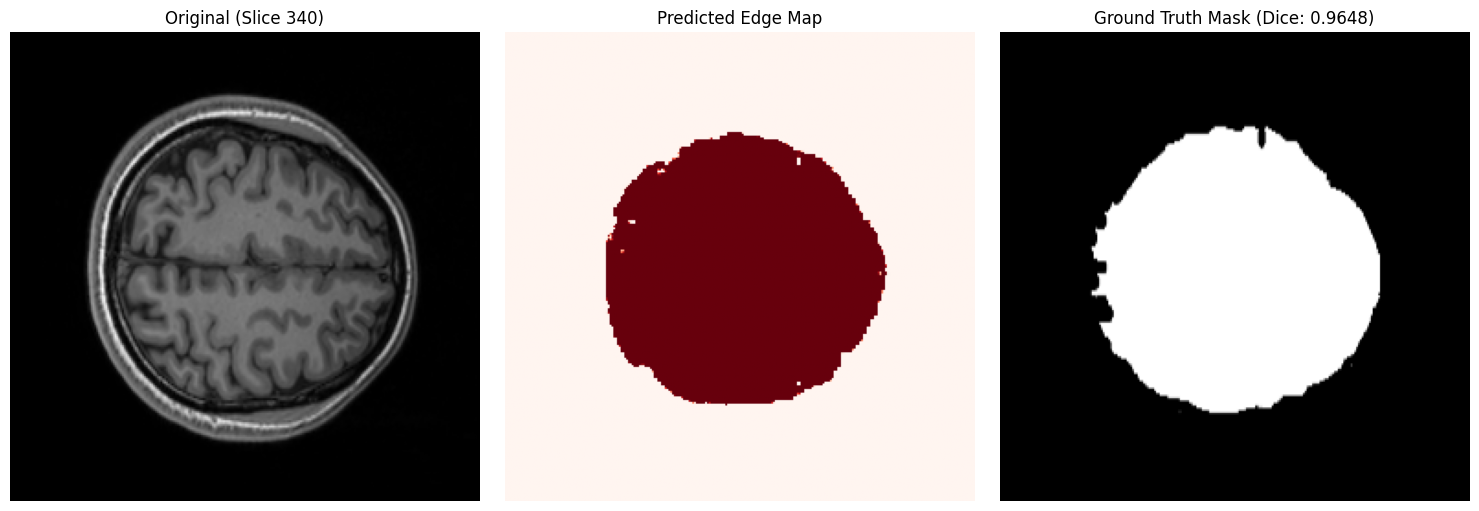

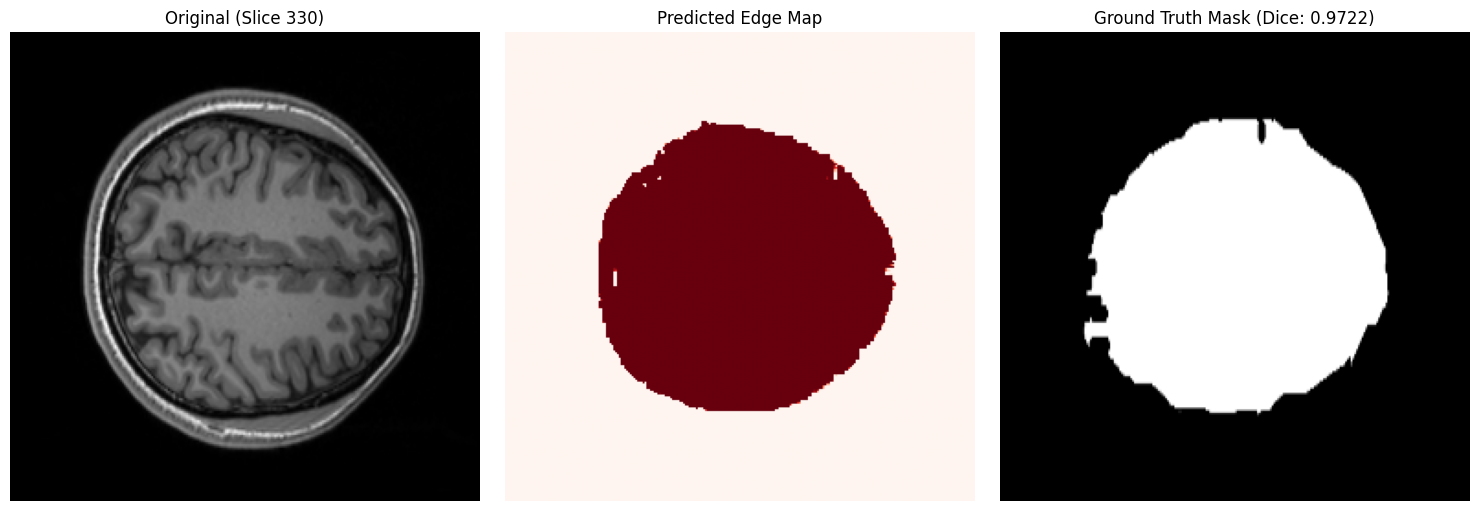

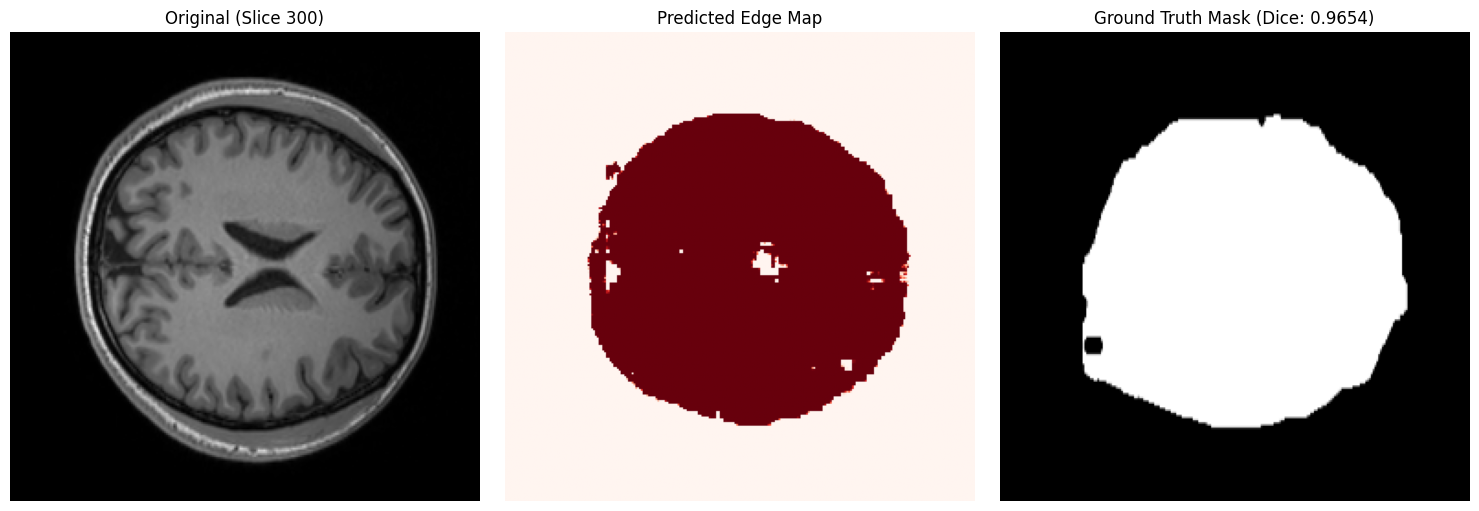

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure `predicted_edges`, `new_images`, `ground_truth_masks`, and `dice_scores` are available from previous cells
# (e.g., cell 'dIqazi_lBUMT' and '0f8c913c' or the updated '3ec05d44')

if 'new_images' not in locals() or \
   'predicted_edges' not in locals() or \
   'ground_truth_masks' not in locals() or \
   'dice_scores' not in locals():
    print("Error: Required variables for visualization are not found.")
    print("Please ensure cells calculating predictions and dice scores have been run.")
else:
    # Create a directory to save the processed images if it doesn't exist
    save_dir = '/content/processed_images'
    os.makedirs(save_dir, exist_ok=True)
    print(f"Saving original vs predicted plots to: {save_dir}")

    # --- Visualize results ---
    # Example: Show specific slice indices
    slice_indices = [100, 340, 330, 300]  # Change these to the indices you want to view

    print("Visualizing selected prediction slices with Dice Coefficients...")
    for slice_idx in slice_indices:
        if slice_idx < len(new_images):
            current_dice_score = dice_scores[slice_idx]

            plt.figure(figsize=(15, 5)) # Adjusted figure size for 3 plots

            # Original Image
            plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
            plt.imshow(new_images[slice_idx, ..., 0], cmap='gray')
            plt.title(f'Original (Slice {slice_idx})')
            plt.axis('off')

            # Predicted Edge Map
            plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
            plt.imshow(predicted_edges[slice_idx, ..., 0], cmap='Reds')
            plt.title('Predicted Edge Map')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
            plt.imshow(ground_truth_masks[slice_idx, ..., 0], cmap='gray')
            plt.title(f'Ground Truth Mask (Dice: {current_dice_score:.4f})')
            plt.axis('off')

            # Save the figure before showing it
            plt.savefig(os.path.join(save_dir, f'slice_{slice_idx}_original_predicted_ground_truth.png'))

            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Slice index {slice_idx} is out of bounds for the prediction dataset.")

### Visualizing Original Image with Applied Processed Mask

This section demonstrates how to overlay the `final_processed_edges_volume` (the morphologically cleaned prediction masks) onto the `new_images` (the original images). This provides a clear visualization of the segmented skull boundaries directly on the input images.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf # Added for preprocess_single_image and tf.stack
from skimage import morphology # Added for morphological operations

# Ensure IMG_HEIGHT and IMG_WIDTH are defined
if 'IMG_HEIGHT' not in globals():
    IMG_HEIGHT = 256 # Default or retrieve from a configuration
if 'IMG_WIDTH' not in globals():
    IMG_WIDTH = 256  # Default or retrieve from a configuration

# Define preprocess_single_image if it's not globally available (copied from dIqazi_lBUMT)
def preprocess_single_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Define dice_coefficient if not globally available
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + epsilon) / (denominator + epsilon)


# Check and re-create `new_images` and `predicted_edges` if not found
if 'new_images' not in locals() or 'predicted_edges' not in locals() or 'image_paths' not in locals():
    print("Re-creating `new_images` and `predicted_edges`...")
    predict_dir = '/content/data/predict_02'
    image_files = sorted([os.path.join(predict_dir, f) for f in os.listdir(predict_dir) if f.endswith('.png')])
    new_images = tf.stack([preprocess_single_image(f) for f in image_files]).numpy()
    image_paths = image_files # Store image_paths for consistency
    # Assuming 'final_model' is loaded and available from 5La9mRGpBLgm
    if 'final_model' in locals():
        predicted_edges = final_model.predict(new_images)
    else:
        print("Warning: 'final_model' not found. Cannot re-create 'predicted_edges'. Please ensure '5La9mRGpBLgm' is run.")
        predicted_edges = np.zeros_like(new_images) # Placeholder

# Check and re-create `final_processed_edges_volume` if not found
if 'final_processed_edges_volume' not in locals() and 'predicted_edges' in locals():
    print("Re-creating `final_processed_edges_volume`...")
    # Logic from 6SKecEoe5mkN
    threshold = 0.5
    pred_binary_volume = (predicted_edges > threshold).astype(np.uint8)
    selem_radius_for_volume = 3
    selem_for_volume = morphology.disk(selem_radius_for_volume)

    temp_final_processed_edges_volume = []
    for i in range(pred_binary_volume.shape[0]):
        slice_2d = pred_binary_volume[i, ..., 0]
        temp_opened = morphology.binary_opening(slice_2d, selem_for_volume)
        processed_slice = morphology.binary_closing(temp_opened, selem_for_volume)
        temp_final_processed_edges_volume.append(processed_slice)
    final_processed_edges_volume = np.array(temp_final_processed_edges_volume)
elif 'final_processed_edges_volume' not in locals():
    print("Error: 'final_processed_edges_volume' not found and cannot be re-created without 'predicted_edges'.")

# Also ensure ground_truth_masks are available for display
if 'ground_truth_masks' not in locals():
    print("Re-creating `ground_truth_masks`...")
    ground_truth_masks_dir = '/content/data/masks_04'
    ground_truth_mask_paths = []
    for img_path in image_paths:
        base_name = os.path.basename(img_path)
        mask_path = os.path.join(ground_truth_masks_dir, base_name)
        ground_truth_mask_paths.append(mask_path)

    ground_truth_masks_list = [preprocess_single_image(f) for f in ground_truth_mask_paths]
    ground_truth_masks = tf.stack(ground_truth_masks_list).numpy()

    if ground_truth_masks.ndim == 3 and new_images.ndim == 4 and new_images.shape[-1] == 1:
        ground_truth_masks = np.expand_dims(ground_truth_masks, axis=-1)

# Now proceed with visualization, using sagittal slices
if 'new_images' in locals() and 'final_processed_edges_volume' in locals() and 'ground_truth_masks' in locals():
    # Create a directory to save the combined images if it doesn't exist
    save_dir = '/content/combined_images_sagittal'
    os.makedirs(save_dir, exist_ok=True)
    print(f"Saving original + processed mask overlays (sagittal view) to: {save_dir}")

    # Convert axial slices to 3D volumes for sagittal slicing
    # Assuming new_images has shape (num_slices, H, W, 1)
    original_3d_volume = new_images[..., 0] # Shape (num_slices, H, W)
    # final_processed_edges_volume already has shape (num_slices, H, W)
    processed_mask_3d_volume = final_processed_edges_volume
    # ground_truth_masks has shape (num_slices, H, W, 1)
    ground_truth_3d_volume = ground_truth_masks[..., 0] # Shape (num_slices, H, W)

    # Select a few sagittal slice indices for visualization
    # Sagittal slices are taken along the width (X) dimension
    sagittal_slice_indices = [IMG_WIDTH // 4, IMG_WIDTH // 2, IMG_WIDTH * 3 // 4] # e.g., [64, 128, 192]

    print("Visualizing original images with overlaid processed masks (sagittal view)...")
    for sagittal_idx in sagittal_slice_indices:
        if 0 <= sagittal_idx < IMG_WIDTH:
            original_sagittal_slice = original_3d_volume[:, :, sagittal_idx] # Shape (num_slices, H)
            processed_mask_sagittal_slice = processed_mask_3d_volume[:, :, sagittal_idx] # Shape (num_slices, H)
            ground_truth_sagittal_slice = ground_truth_3d_volume[:, :, sagittal_idx] # Shape (num_slices, H)

            # Calculate Dice coefficient for the current sagittal slice
            y_pred_sagittal_tf = tf.convert_to_tensor(processed_mask_sagittal_slice)
            y_true_sagittal_tf = tf.convert_to_tensor(ground_truth_sagittal_slice)
            current_dice_score = dice_coefficient(y_true_sagittal_tf, y_pred_sagittal_tf).numpy()

            # Create an overlay for visualization
            overlay_mask_rgb = np.zeros((original_sagittal_slice.shape[0], original_sagittal_slice.shape[1], 3), dtype=np.float32)
            overlay_mask_rgb[processed_mask_sagittal_slice == 1, 0] = 1.0  # Set red channel to 1 where mask is 1

            original_image_rgb = np.stack([original_sagittal_slice, original_sagittal_slice, original_sagittal_slice], axis=-1)

            alpha = 0.4 # Transparency of the overlay
            combined_image = original_image_rgb * (1 - alpha) + overlay_mask_rgb * alpha
            combined_image = np.clip(combined_image, 0, 1) # Ensure values are within valid range

            plt.figure(figsize=(10, 5))

            # Original Sagittal Slice
            plt.subplot(1, 2, 1)
            plt.imshow(original_sagittal_slice, cmap='gray', origin='lower') # origin='lower' is common for medical images
            plt.title(f'Original (Sagittal Slice {sagittal_idx})')
            plt.xlabel('Height')
            plt.ylabel('Axial Slice Index')
            plt.axis('off')

            # Sagittal Slice with Processed Mask Overlay
            plt.subplot(1, 2, 2)
            plt.imshow(combined_image, origin='lower')
            plt.title(f'Original + Processed Mask (Dice: {current_dice_score:.4f})')
            plt.xlabel('Height')
            plt.ylabel('Axial Slice Index')
            plt.axis('off')

            # Save the figure
            plt.savefig(os.path.join(save_dir, f'sagittal_slice_{sagittal_idx}_original_with_processed_mask.png'))
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Sagittal slice index {sagittal_idx} is out of bounds for image width.")
else:
    print("Error: Essential variables `new_images`, `final_processed_edges_volume`, or `ground_truth_masks` are still missing after attempt to re-create.")

Re-creating `ground_truth_masks`...


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/data/masks_04/slice_000_original.png; No such file or directory [Op:ReadFile]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have the necessary data
if 'new_images' in locals() and 'predicted_edges' in locals():
    # Select a few slices to visualize (e.g., middle of the stack)
    num_slices = new_images.shape[0]
    indices = [0, num_slices // 2, 3 * num_slices // 4]

    threshold = 0.5

    plt.figure(figsize=(18, 6))

    for i, idx in enumerate(indices):
        # 1. Prepare the background (original image)
        # Shape is (H, W, 1), convert to (H, W)
        img = new_images[..., idx, 0]

        # 2. Prepare the mask (thresholded prediction)
        mask = (predicted_edges[idx, ..., 0] > threshold).astype(float)

        # Create an RGBA mask for overlay
        # Red channel = 1, Green/Blue = 0, Alpha = mask * 0.5
        overlay = np.zeros((*img.shape, 4))
        overlay[..., 0] = 1.0  # Red
        overlay[..., 3] = mask * 0.5  # Transparency where mask is 1

        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img, cmap='gray')
        plt.imshow(overlay)
        plt.title(f"Slice {idx} Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Error: Please ensure you have run the prediction cell ('dIqazi_lBUMT') first.")

ValueError: could not broadcast input array from shape (256,256) into shape (192,256)

<Figure size 1800x600 with 0 Axes>

If the maximum values are very low (e.g., much less than 0.5), it would explain why the binarized images appear blank. In that case, you might try a lower `threshold` in cell `6SKecEoe5mkN` (e.g., `0.1` or `0.05`) to see if any edges become visible. This could indicate the model is outputting subtle edge probabilities that are just below the default threshold.

### Post-processing with Morphological Operations

Morphological operations are a set of image processing techniques that process images based on shapes. They are typically applied to binary images.

*   **Thresholding**: Converts the probability map output by the model (`predicted_edges`) into a binary image (0s and 1s) by setting a cutoff value. Pixels above the threshold become 1 (edge), and below become 0 (no edge).
*   **Erosion**: Shrinks the boundaries of foreground objects (white regions). This can help remove small isolated noise pixels or thin lines.
*   **Dilation**: Expands the boundaries of foreground objects. This can help fill small holes and connect fragmented components.
*   **Opening**: An erosion followed by a dilation. It's useful for removing small objects from an image while preserving the shape and size of larger objects.
*   **Closing**: A dilation followed by an erosion. It's useful for filling small holes and gaps within foreground objects.

In [ ]:
import os
import skimage.morphology
import numpy as np

# Define global image dimensions (these are already defined in the main script)
# IMG_HEIGHT = 256
# IMG_WIDTH = 256

### Fine-tuning the existing model

Now that the `train_dataset` is configured to provide morphologically post-processed ground truth labels, we can load the previously trained model and continue training (fine-tune) it with these updated targets. This will allow the model to adapt its predictions to the cleaner labels.

In [ ]:
from tensorflow.keras.models import load_model

# Define the dice_loss function, as it's a custom object
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + epsilon) / (denominator + epsilon)

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = 1e-7
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + epsilon) / (denominator + epsilon)

# Load the previously saved model
fine_tune_1_model = load_model('/content/drive/MyDrive/models/first_4_layers_fine_tune4.keras', custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

print("Model loaded successfully for fine-tuning.")

Model loaded successfully for fine-tuning.


In [ ]:
import tensorflow as tf

# Re-compile the model. This is important even for fine-tuning.
# You might consider a lower learning rate for fine-tuning to avoid overfitting.
# For now, we'll use the same Adam optimizer.
# To reduce the learning rate, we'll create an instance of the Adam optimizer
# with a specified learning_rate.
fine_tune_1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=dice_loss, metrics=['accuracy', dice_coefficient])

print("Model re-compiled with a reduced learning rate.")

# Train the model with the updated train_dataset
# You can choose the number of epochs for fine-tuning.
# Start with a few epochs and monitor the loss and accuracy.
epochs_for_finetuning = 100 # You can adjust this number
history = fine_tune_1_model.fit(train_dataset, epochs=epochs_for_finetuning)

print("Fine-tuning complete.")

save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)  # Creates the folder if it doesn't exist

fine_tune_1_model.save(os.path.join(save_dir, 'first_4_layers_fine_tune4.keras'))

Model re-compiled with a reduced learning rate.
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9841 - dice_coefficient: 0.8526 - loss: 0.1474
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9838 - dice_coefficient: 0.8510 - loss: 0.1490
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9840 - dice_coefficient: 0.8529 - loss: 0.1471
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9829 - dice_coefficient: 0.8367 - loss: 0.1633
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9836 - dice_coefficient: 0.8487 - loss: 0.1513
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9845 - dice_coefficient: 0.8559 - loss: 0.1441
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9832 - dice_coefficient: 0.8438 - loss: 0.1562
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9841 - dice_coefficient: 0.8508 - loss: 0.1492
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/

In [ ]:
import os
import numpy as np

# Assuming image_paths and predicted_edges are available from previous cells
# (e.g., cell 'dIqazi_lBUMT')

if 'image_paths' not in locals() or 'predicted_edges' not in locals():
    print("Error: 'image_paths' or 'predicted_edges' not found. Please run prediction cells first.")
else:
    # Define the directory where ground truth masks are located
    # This assumes a consistent naming convention and directory structure
    ground_truth_masks_dir = '/content/data/masks_04'

    # Generate paths for the corresponding ground truth masks
    # We need to replace the 'preds_04' part of the path with 'masks_04'
    ground_truth_mask_paths = []
    for img_path in image_paths:
        base_name = os.path.basename(img_path)
        mask_path = os.path.join(ground_truth_masks_dir, base_name)
        ground_truth_mask_paths.append(mask_path)

    # Load and preprocess the ground truth masks
    # Using the same preprocess_single_image function from cell 'dIqazi_lBUMT'
    ground_truth_masks_list = [preprocess_single_image(f) for f in ground_truth_mask_paths]
    ground_truth_masks = tf.stack(ground_truth_masks_list).numpy()

    # Ensure shapes match for comparison (predicted_edges usually has a batch dimension already)
    print(f"Shape of predicted_edges: {predicted_edges.shape}")
    print(f"Shape of ground_truth_masks: {ground_truth_masks.shape}")

    if predicted_edges.shape != ground_truth_masks.shape:
        print("Warning: Predicted edges and ground truth masks have different shapes. Reshaping ground truth if necessary.")
        # Attempt to reshape ground_truth_masks if it's missing the channel dimension
        if ground_truth_masks.ndim == 3 and predicted_edges.ndim == 4 and predicted_edges.shape[-1] == 1:
            ground_truth_masks = np.expand_dims(ground_truth_masks, axis=-1)
            print(f"Reshaped ground_truth_masks to: {ground_truth_masks.shape}")

    # Calculate Dice Coefficient for each image pair
    dice_scores = []
    for i in range(len(predicted_edges)):
        # Ensure inputs to dice_coefficient are tf.Tensors
        y_pred_tf = tf.convert_to_tensor(predicted_edges[i])
        y_true_tf = tf.convert_to_tensor(ground_truth_masks[i])
        score = dice_coefficient(y_true_tf, y_pred_tf)
        dice_scores.append(score.numpy())

    average_dice_coefficient = np.mean(dice_scores)

    print(f"\nAverage Dice Coefficient on prediction dataset: {average_dice_coefficient:.4f}")

Shape of predicted_edges: (453, 256, 256, 1)
Shape of ground_truth_masks: (453, 256, 256, 1)

Average Dice Coefficient on prediction dataset: 0.7439


### Visualize Training History (Fine-tuning)

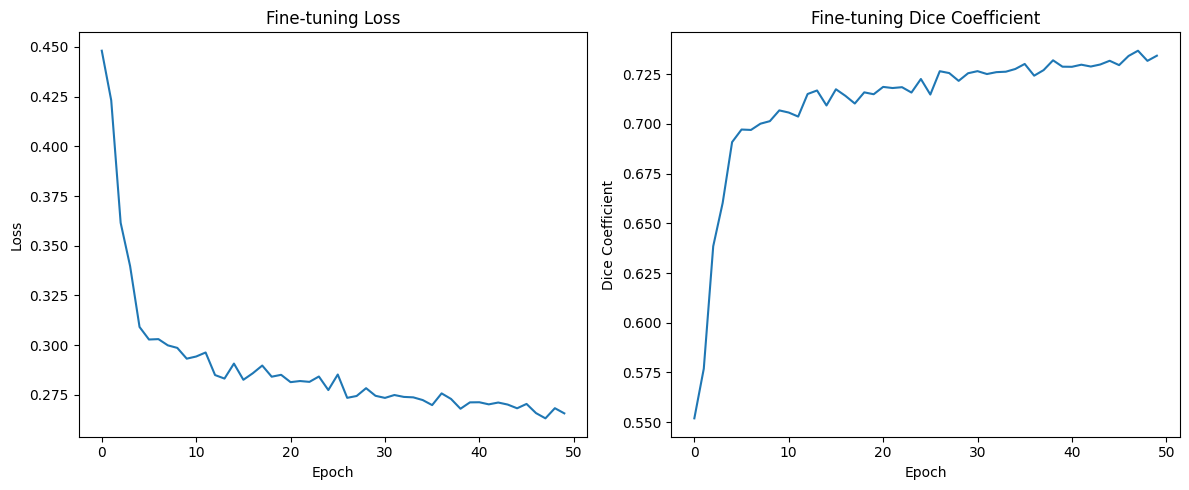

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Dice Coefficient
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'])
plt.title('Fine-tuning Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt
import os

# Ensure `predicted_edges` and `new_images` are available from previous cells

# 1. Binarize the predicted edges using a threshold
threshold = 0.5
pred_binary_volume = (predicted_edges > threshold).astype(np.uint8) # Full volume of binarized predictions

# 2. Apply morphological operations to the entire volume
# We'll use a single structuring element radius for consistency across the volume.
# Radius=2 is chosen as a reasonable default for opening and closing.
selem_radius_for_volume = 3
selem_for_volume = morphology.disk(selem_radius_for_volume)

final_processed_edges_volume = []
for i in range(pred_binary_volume.shape[0]): # Iterate through each slice
    # Reshape to 2D for skimage morphology functions (remove channel dimension)
    slice_2d = pred_binary_volume[i, ..., 0]

    # Apply opening then closing
    temp_opened = morphology.binary_opening(slice_2d, selem_for_volume)
    processed_slice = morphology.binary_closing(temp_opened, selem_for_volume)

    final_processed_edges_volume.append(processed_slice)

# Convert the list of 2D processed slices into a single 3D NumPy array
# The shape will be (num_slices, IMG_HEIGHT, IMG_WIDTH)
final_processed_edges_volume = np.array(final_processed_edges_volume)

# Create a directory to save the processed images
save_dir = '/content/processed_images'
os.makedirs(save_dir, exist_ok=True)
print(f"Saving processed images to: {save_dir}")

# 3. Visualize the results for a few examples (for verification)
num_examples_to_show = 2
# Select indices that you found to be interesting for visualization
slice_indices = [330, 300] # Example indices for visualization



for i, slice_idx in enumerate(slice_indices):
    if slice_idx < len(new_images):
        plt.figure(figsize=(12, 5)) # Adjust figure size for 3 plots

        # Plot Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(new_images[slice_idx, ..., 0], cmap='gray')
        plt.title(f'Original (Slice {slice_idx})')
        plt.axis('off')

        # Plot Initial Binarized Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(pred_binary_volume[slice_idx, ..., 0], cmap='Reds')
        plt.title(f'Predicted (Thresh={threshold})')
        plt.axis('off')

        # Plot Final Processed Image
        plt.subplot(1, 3, 3)
        plt.imshow(final_processed_edges_volume[slice_idx], cmap='Reds')
        plt.title(f'Open & Close (selem={selem_radius_for_volume})')
        plt.axis('off')

        # Save the entire figure before showing it
        plt.savefig(os.path.join(save_dir, f'slice_{slice_idx}_comparison.png'))

        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: slice_index {slice_idx} is out of bounds for the number of images ({len(new_images)}).")




Applying morphological cleanup to volume...


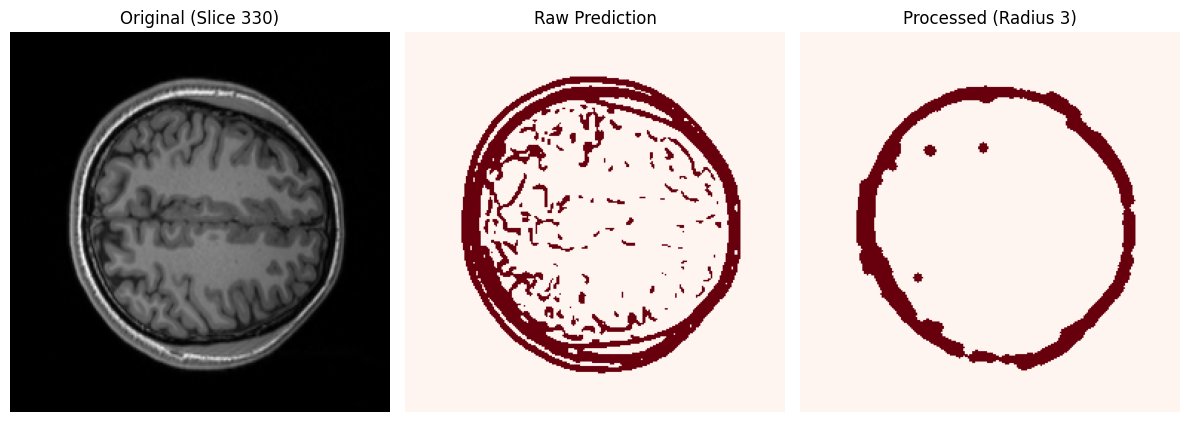

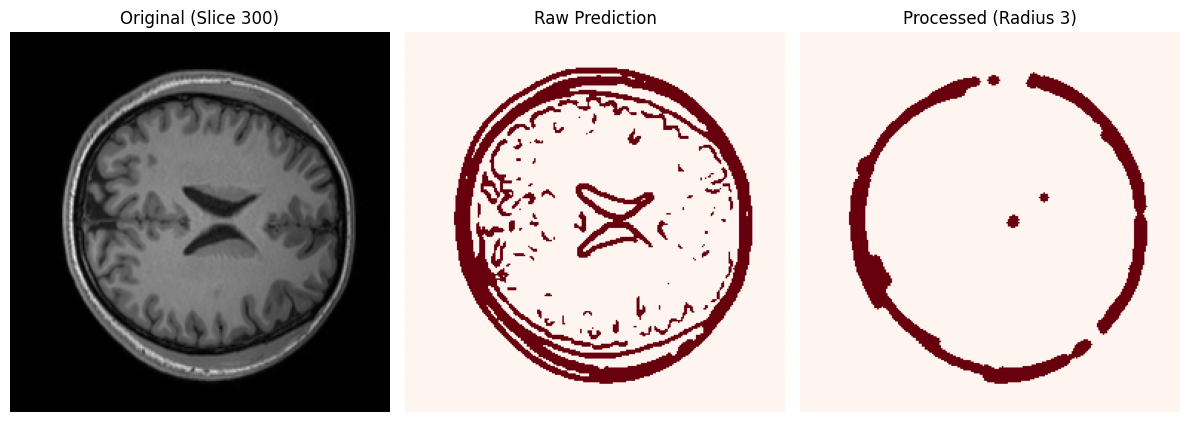


✅ EXPORT COMPLETE
File Name: processed_skull_mask.bin
Array Shape: (453, 256, 256) (Slices, Height, Width)
Total Bytes: 29687808
Expected WebGPU Width: 256
Expected WebGPU Height: 256
Expected WebGPU Depth: 453
  adding: processed_skull_mask.bin (deflated 98%)


In [ ]:
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt
import os

# --- PART 1: Morphological Post-Processing ---

# 1. Binarize the predicted edges using a threshold
# Ensure `predicted_edges` (shape: [slices, H, W, 1]) is available
threshold = 0.5
pred_binary_volume = (predicted_edges > threshold).astype(np.uint8)

# 2. Apply morphological operations to the entire volume
# Using radius=3 as your preferred setting for skull-brain boundary
selem_radius_for_volume = 3
selem_for_volume = morphology.disk(selem_radius_for_volume)

final_processed_edges_volume = []
print("Applying morphological cleanup to volume...")

for i in range(pred_binary_volume.shape[0]):
    # Reshape to 2D (remove channel dimension)
    slice_2d = pred_binary_volume[i, ..., 0]

    # Apply opening (remove noise) then closing (fill gaps)
    temp_opened = morphology.binary_opening(slice_2d, selem_for_volume)
    processed_slice = morphology.binary_closing(temp_opened, selem_for_volume)

    final_processed_edges_volume.append(processed_slice)

# Convert list to 3D NumPy array: Shape (num_slices, IMG_HEIGHT, IMG_WIDTH)
final_processed_edges_volume = np.array(final_processed_edges_volume)

# --- PART 2: Visual Verification ---

save_dir = '/content/processed_images'
os.makedirs(save_dir, exist_ok=True)

slice_indices = [330, 300]
for slice_idx in slice_indices:
    if slice_idx < len(new_images):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(new_images[slice_idx, ..., 0], cmap='gray')
        plt.title(f'Original (Slice {slice_idx})')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_binary_volume[slice_idx, ..., 0], cmap='Reds')
        plt.title(f'Raw Prediction')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(final_processed_edges_volume[slice_idx], cmap='Reds')
        plt.title(f'Processed (Radius {selem_radius_for_volume})')
        plt.axis('off')

        plt.savefig(os.path.join(save_dir, f'slice_{slice_idx}_comparison.png'))
        plt.tight_layout()
        plt.show()

# --- PART 3: WebGPU Binary Export ---

# 4. Convert boolean True/False to uint8 (0 and 255)
# This is what the GPU 'r8unorm' format expects to map to 0.0-1.0
export_volume = (final_processed_edges_volume * 255).astype(np.uint8)

# 5. Save as Raw Binary (.bin)
# This flattens the array so slices are concatenated one after another
file_name = "processed_skull_mask.bin"
export_volume.tofile(file_name)

print("\n" + "="*30)
print(f"✅ EXPORT COMPLETE")
print(f"File Name: {file_name}")
print(f"Array Shape: {export_volume.shape} (Slices, Height, Width)")
print(f"Total Bytes: {export_volume.size}")
print(f"Expected WebGPU Width: {export_volume.shape[2]}")
print(f"Expected WebGPU Height: {export_volume.shape[1]}")
print(f"Expected WebGPU Depth: {export_volume.shape[0]}")
print("="*30)

# Optional: Zip for faster download from the Colab sidebar
!zip processed_skull_mask.zip processed_skull_mask.bin